In this notebook, I approach the house prices competition on Kaggle using XGBoost. This is a powerful ensemble learning method, but seems to have a propensity to overfit. The exploratory data analysis and cleaning is the same as in the basic linear regression notebook, so this is not extrapolated on.

Overall, the model doesn't perform as well as the linear regression. In particular, it seems to really struggle with expensive or cheap houses, and suggests that more data could be useful to improve the model. This isn't practical in this situation, but might be something to consider in actual applications. 

In [1]:
import numpy as np
import pandas as pd
from math import log
%matplotlib inline 
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
warnings.filterwarnings('ignore')


train_data = pd.read_csv("home-data-for-ml-course/train.csv")
test_data = pd.read_csv("home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
train_data = train_data.copy()
test_data = test_data.copy()
train_data.set_index('Id', inplace = True)
test_data.set_index('Id', inplace = True);

In the following, it is not necessary to normalise or transform the data, as it was when we used a linear regression model, since we are using XGBoostRegressor, which is based on decision trees. On the other hand, feature selection is important, and I will do the same feature engineering as in the linear regression.

In [2]:
ToDrop = ['Utilities', 'Street', 'YearRemodAdd', 'GarageYrBlt']
Bathrooms = ['BsmtFullBath','BsmtHalfBath', 'FullBath', 'HalfBath']
DeckSqF = ['WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch']
TotalArea = ['BsmtFinSF1','BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'GarageArea','BsmtUnfSF']


train_data['Bathrooms'] = sum([train_data[column] for column in Bathrooms])
train_data['DeckSqF'] = sum([train_data[column] for column in DeckSqF]) 
train_data['TotalArea'] = sum([train_data[column] for column in TotalArea]) 
test_data['Bathrooms'] = sum([test_data[column] for column in Bathrooms])
test_data['DeckSqF'] = sum([test_data[column] for column in DeckSqF]) 
test_data['TotalArea'] = sum([test_data[column] for column in TotalArea]) 

train_data.drop([column for column in ToDrop + Bathrooms + DeckSqF + TotalArea], axis = 1, inplace = True)
test_data.drop([column for column in ToDrop + Bathrooms + DeckSqF + TotalArea], axis = 1, inplace = True)

In [3]:
y = train_data.SalePrice
train_data.drop('SalePrice',axis = 1,inplace = True)

In [4]:

categorical_cols = [cname for cname in train_data.columns if train_data[cname].dtype == "object"]
numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
    

numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



It seems that XGBoost regressors have a strong propensity to overfit, at least with the amount of data we have. Correspondingly, there are a lot of hyperparameters we can tune to regularise. It is computationally impractical to find good parameters, even if we used a stochastic method and then iterated. To get around this, I will do the following: 

* Define the distributions for my hyperparameters.
* Iterate a fixed (and reasonable) number of times, choosing a random configuration of parameters each time.
* If some of the parameters are getting chosen to be at the bounds of what I thought a reasonable range of values was, then reevaluate what reasonable values are and retune the model.


In [5]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV


X_train, X_test, y_train, y_test = train_test_split(train_data, y, train_size = 0.8, random_state = 42)

model = XGBRegressor()
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor), 
                              ('model', model)
                             ])
subsample_val, reg_lambda_val, eta_val, max_depth_val, min_child_weight_val, n_estimators_val, lr = 0,0,0,0,0,0,0


parameters={'model__subsample' : np.logspace(-1,1,10), 'model__reg_lambda': np.logspace(-1,1,10), 'model__eta' : np.logspace(-1,0,10), 
            'model__max_depth' : [2,3,4,5,6], 'model__min_child_weight' : np.logspace(0,1,10), 
            'model__learning_rate': np.logspace(-2,0,10), 'model__n_estimators' : [250 +50*i for i in range(50)]}

search = RandomizedSearchCV(my_pipeline, param_distributions = parameters, n_iter = 100, scoring = 'neg_mean_squared_error', cv = 5)
search.fit(X_train, y_train)
subsample_val = search.best_params_['model__subsample']
reg_lambda_val = search.best_params_['model__reg_lambda']
eta_val = search.best_params_['model__eta']
min_child_weight_val = search.best_params_['model__min_child_weight']
max_depth_val = search.best_params_['model__max_depth']
n_estimators_val = search.best_params_['model__n_estimators']
lr = search.best_params_['model__learning_rate']

print(subsample_val, reg_lambda_val, max_depth_val, eta_val, min_child_weight_val, n_estimators_val, lr)



0.46415888336127786 5.994842503189409 5 0.16681005372000587 10.0 1850 0.016681005372000592


Like with these the linear regression model, I will train lots of models on some subset of the data and then average. This potentially has the issue that the hyperparameters I found were optimised for an $80\%$ training split, whilst I am now using a $40\%$ split of the training data. It seems to not be so bad though, at least away from the very expensive houses. This is certainly something I should come back to to further explore. 

0
10
20
30
40
50
60
70
80
90


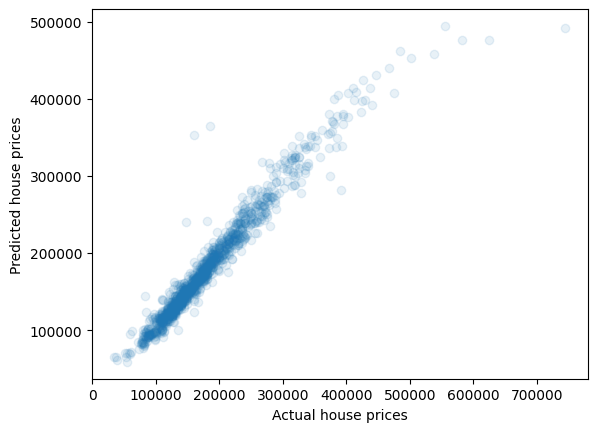

In [6]:
model = XGBRegressor(subsample = subsample_val, reg_lambda = reg_lambda_val, max_depth = max_depth_val, eta = eta_val,
                n_estimators = n_estimators_val, learning_rate = lr)
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor), 
                              ('model', model)
                             ])
output = np.zeros((y_train.size))
iterations = 100
for i in range(iterations):
    X_multiple_train, _, y_multiple_train, _ = train_test_split(X_train, y_train, train_size = 0.4) 
    my_pipeline.fit(X_multiple_train, y_multiple_train)
    output = np.add(output, my_pipeline.predict(X_train))
    if i %10 == 0:
        print(i)
y_train_predict = output / iterations
plt.scatter(y_train, y_train_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()

In [7]:
RMSE_train = mean_squared_error(np.log(y_train_predict), np.log(y_train))**0.5
print(f"RMSE of the training data is: {RMSE_train}")

RMSE of the training data is: 0.08600585009005356


This is a relatively good score, but is clearly still overfit. There is also a noticeable curve as the house prices go above about $\$500,000$, which might reflect that there are not so many training examples in this range, or that there is something wrong with my model (or both). In any case, it will almost certainly perform pooly on unseen data in this range. 

0
10
20
30
40
50
60
70
80
90


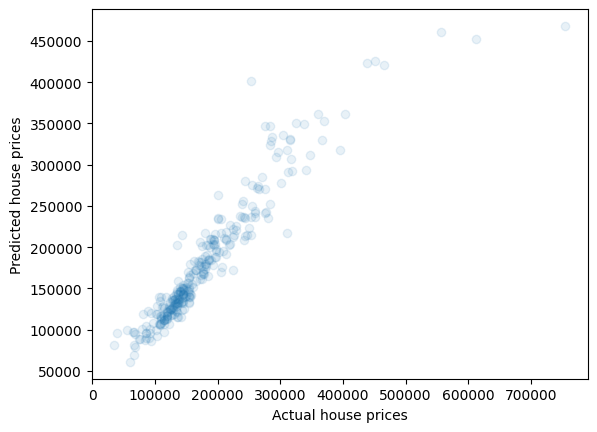

In [8]:
output = np.zeros((y_test.size))
iterations = 100
for i in range(iterations):
    X_multiple_train, _, y_multiple_train, _ = train_test_split(X_train, y_train, train_size = 0.4)
    my_pipeline.fit(X_multiple_train, y_multiple_train)
    output = np.add(output, my_pipeline.predict(X_test))
    if i % (iterations / 10) == 0:
        print(i)
y_test_predict = output / iterations
plt.scatter(y_test, y_test_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()

In [9]:
RMSE_test = mean_squared_error(np.log(y_test), np.log(y_test_predict))**0.5
print(f"RMSE of the training data is: {RMSE_test}")

RMSE of the training data is: 0.14182385713410267


Yes, this is performing poorly for expensive unseen houses. It is also very overfit, as indicated by the difference in RMSE of the training and validation data. The most obvious solution would be to find more data to train on with expensive houses, but this isn't possible in this situation (it's a fixed amount of data for a Kaggle competition). Failing this, the potential improvements which spring to mind are:
* As in the linear regression model, it might help to explicitly write a train-test-split function which ensures the validation data and training data come from the same distributions. We particularly don't want for all of the expensive houses to be in one set or the other, for example.
* We could do feature selection as part of our algorithm, meaning we tell the model to pick the most important features after it's been trained, and then retrain the model with just these features. This could be tricky though, since there are several natural metrics for what `most important' could mean. Since XGBoost is a tree regressor, this could mean how many times the data is split on that feature, or what the average information gain is on splitting on that feature. I'm not sure which metric would make the most sense in this instance.